In [ ]:
!pip install eli5
!pip install pdpbox
!pip install shap

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from xgboost import XGBClassifier, plot_importance
import warnings
import eli5
import shap
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

In [ ]:
data = pd.read_csv('/content/heartu.csv')
# To display the top 5 rows
data.head(5)

age  sex  cp  trestbps  chol  ...  oldpeak  slope  ca  thal  condition
0   69    1   0       160   234  ...      0.1      1   1     0          0
1   69    0   0       140   239  ...      1.8      0   2     0          0
2   66    0   0       150   226  ...      2.6      2   0     0          0
3   65    1   0       138   282  ...      1.4      1   1     0          1
4   64    1   0       110   211  ...      1.8      1   0     0          0

[5 rows x 14 columns]

In [ ]:
data.describe()

age         sex          cp  ...          ca        thal   condition
count  297.000000  297.000000  297.000000  ...  297.000000  297.000000  297.000000
mean    54.542088    0.676768    2.158249  ...    0.676768    0.835017    0.461279
std      9.049736    0.468500    0.964859  ...    0.938965    0.956690    0.499340
min     29.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%     48.000000    0.000000    2.000000  ...    0.000000    0.000000    0.000000
50%     56.000000    1.000000    2.000000  ...    0.000000    0.000000    0.000000
75%     61.000000    1.000000    3.000000  ...    1.000000    2.000000    1.000000
max     77.000000    1.000000    3.000000  ...    3.000000    2.000000    1.000000

[8 rows x 14 columns]

In [ ]:
data.shape

(297, 14)

In [ ]:
heart = data.copy()

In [ ]:
target = 'condition'
features_list = list(heart.columns)
features_list.remove(target)

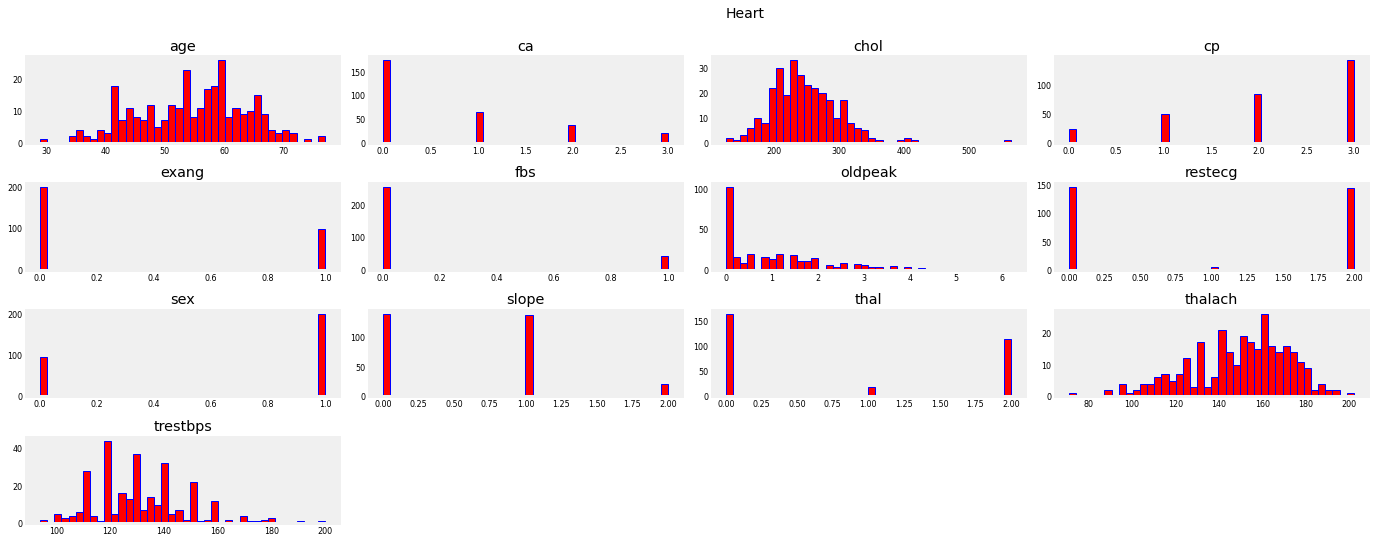

In [ ]:
heart[features_list].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Heart', x=0.65, y=1.25, fontsize=14);

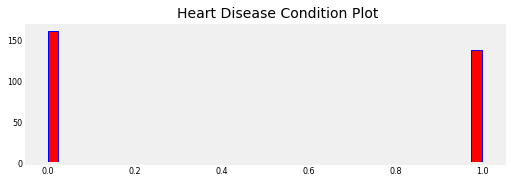

In [ ]:
heart[target].hist(bins=40, edgecolor='b', linewidth=1.0,
              xlabelsize=8, ylabelsize=8, grid=False, figsize=(6,2), color='red')    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Heart Disease Condition Plot', x=0.65, y=1.25, fontsize=14);

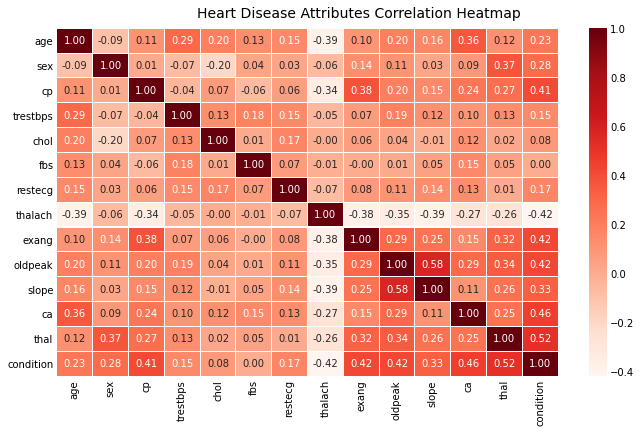

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
corr = heart.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Heart Disease Attributes Correlation Heatmap', fontsize=14)

In [ ]:
y = heart.pop('condition')

In [ ]:
y.sum() / len(y)

0.4612794612794613

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(heart, y, test_size=0.2, random_state=33)
X_train.shape, X_test.shape

((237, 13), (60, 13))

In [ ]:
%%time

# ML in two lines ;)
xgb = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb.fit(X_train, y_train)

CPU times: user 53.2 ms, sys: 9.26 ms, total: 62.4 ms
Wall time: 40.8 ms


In [ ]:
# make predictions for test data
xgb_predictions = xgb.predict(X_test)

In [ ]:
# We design a simple classification evaluative function
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(metrics.accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', metrics.classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame)

In [ ]:
# Evaluate predictions
evaluation_scores(y_test, xgb_predictions, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.8333
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.72      0.91      0.81        23
Hight Quality       0.94      0.78      0.85        37

     accuracy                           0.83        60
    macro avg       0.83      0.85      0.83        60
 weighted avg       0.85      0.83      0.84        60



TypeError: ignored

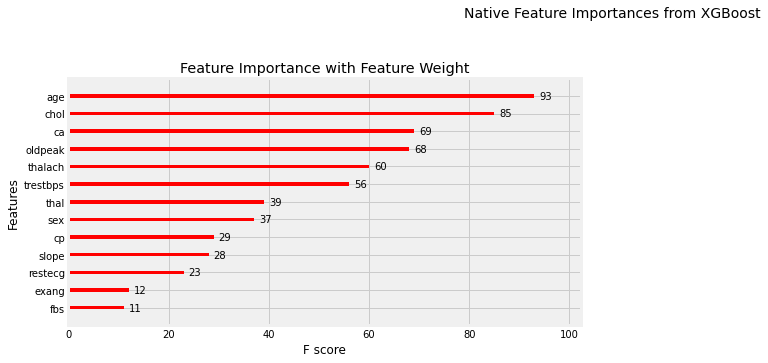

In [ ]:
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (18, 10))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', ax=ax1, color='red')
ax1.set_title("Feature Importance with Feature Weight");

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
y_test

222    1
145    0
234    1
260    1
186    1
11     1
199    1
56     0
285    0
277    1
255    1
264    1
204    1
187    1
270    1
193    1
219    1
279    1
62     0
35     1
164    1
192    1
154    0
250    1
271    0
268    0
162    1
1      0
159    1
221    1
157    1
218    0
273    1
158    1
149    0
140    0
4      0
29     0
280    1
54     0
294    1
196    1
229    1
266    0
247    1
81     0
17     0
103    1
230    1
101    0
38     0
185    1
69     0
214    1
95     0
85     0
288    1
242    1
228    1
176    0
Name: condition, dtype: int64

In [ ]:
eli5.show_weights(xgb.get_booster(), top=30)

In [ ]:
tgt = 4
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 1
Predicted: 1


In [ ]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', xgb_predictions[tgt])
eli5.show_prediction(xgb.get_booster(), X_test.iloc[tgt], 
                     feature_names=list(heart.columns), show_feature_values=True)

Reference: 0
Predicted: 0


In [ ]:
%%time

# we need to retrain a new model with arrays
# as eli5 has a bug with Dataframes and XGBoost
# cf. https://github.com/TeamHG-Memex/eli5/pull/261
xgb_array = XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)
xgb_array.fit(X_train.values, y_train)

CPU times: user 48.6 ms, sys: 2.83 ms, total: 51.4 ms
Wall time: 30.7 ms


In [ ]:
model = DecisionTreeClassifier(random_state=1)
model = model.fit(X_train, y_train)

In [ ]:
permutation = PermutationImportance(model, random_state=21).fit(X_train, y_train)

In [ ]:
eli5.show_weights(permutation, feature_names = features_list, top=30)

In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


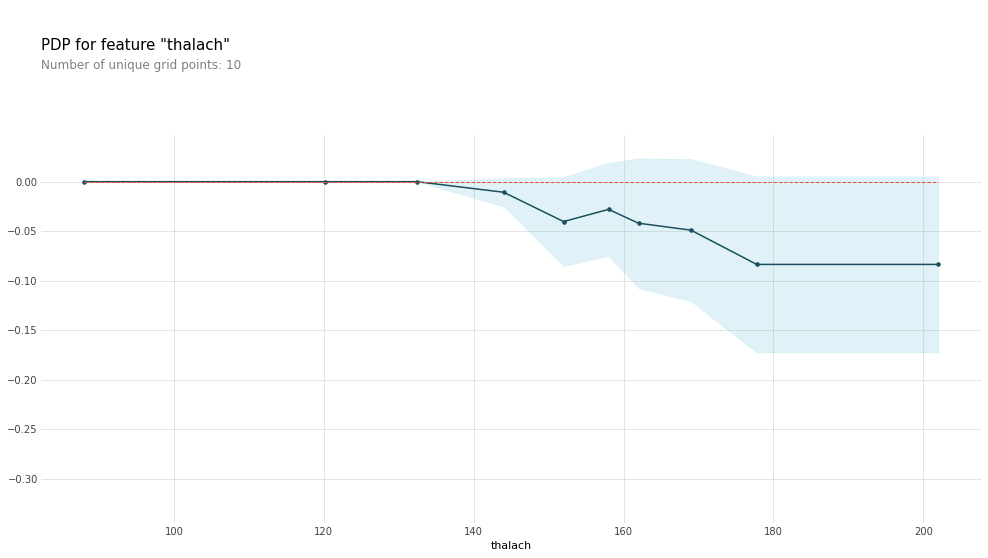

In [ ]:
plot_pdp(xgb, X_train, 'thalach')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


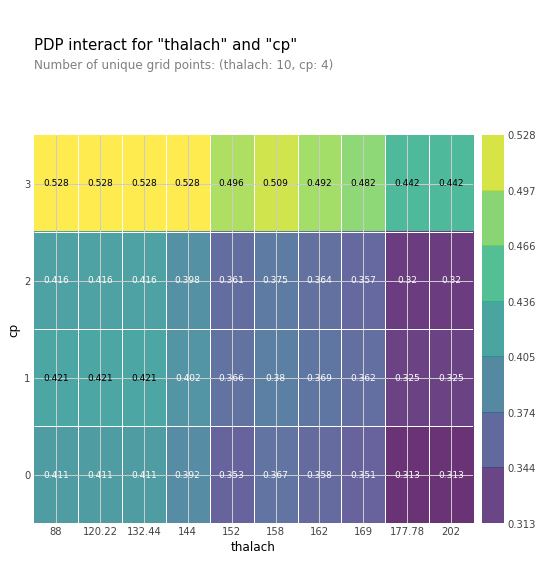

In [ ]:
features_to_plot = ['thalach', 'cp']
inter1  =  pdp.pdp_interact(model=xgb, dataset=X_train, model_features=features_list, features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

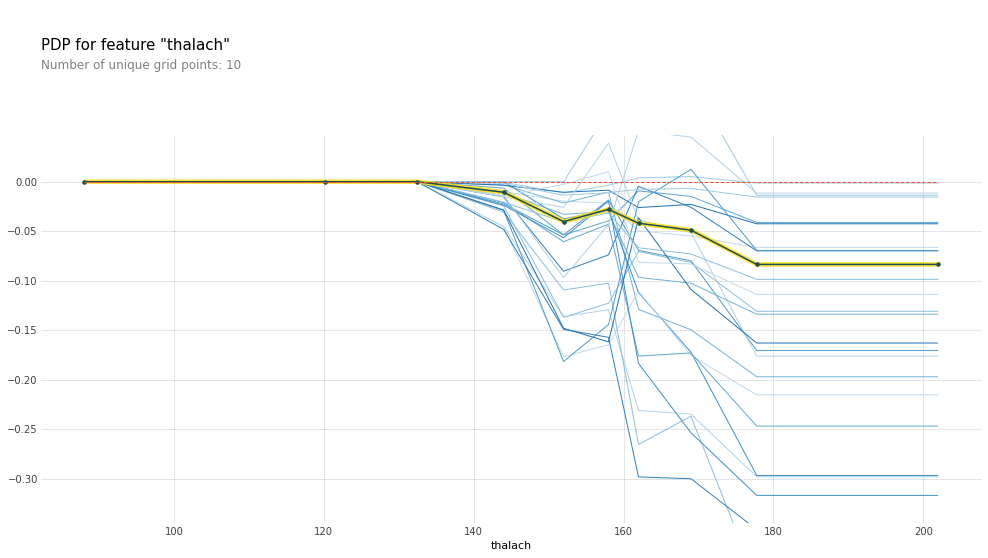

In [ ]:
plot_pdp(xgb, X_train, 'thalach', cluster_flag=True, nb_clusters=24, lines_flag=True)

In [ ]:
!pip install skater

In [ ]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [ ]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=features_list)
im_model = InMemoryModel(xgb.predict_proba, examples=X_train, target_names=['Disease', 'No Disease'])

In [ ]:
predictions = xgb_array.predict_proba(X_test.values)


In [ ]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=features_list, discretize_continuous=True, class_names=['Low Quality', 'High Quality'])

In [ ]:
tgt = 1
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 0
Predicted: [0.9808606 0.0191394]


In [ ]:
tgt = 4
print('Reference:', y_test.iloc[tgt])
print('Predicted:', predictions[tgt])
exp.explain_instance(X_test.iloc[tgt].values, xgb_array.predict_proba).show_in_notebook()

Reference: 1
Predicted: [0.01886982 0.9811302 ]


In [ ]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=33)


In [ ]:
f1 = surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')
print('F1 score for the surrogate tree: ', f1)

2020-08-06 09:16:12,570 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2020-08-06 09:16:12,579 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2020-08-06 09:16:12,844 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (237, 2)
2020-08-06 09:16:12,850 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.872; oracle score 0.979
2020-08-06 09:16:12,852 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.107 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


F1 score for the surrogate tree:  0.107


In [ ]:
# A reminder for referencing the originals feature names 
# since these names are not kept in the surrogate tree
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(heart.columns)]).T

0    1   2         3     4    5   ...       7      8        9      10   11    12
0   X0   X1  X2        X3    X4   X5  ...       X7     X8       X9    X10  X11   X12
1  age  sex  cp  trestbps  chol  fbs  ...  thalach  exang  oldpeak  slope   ca  thal

[2 rows x 13 columns]

In [ ]:
from skater.util.dataops import show_in_notebook

# 'Low Quality' (score <= 5) class in pink and 'High Quality' class (score > 5) in red
surrogate_explainer.plot_global_decisions(colors=['pink', 'red'], file_name='img/test_tree_sur.png', fig_size=(8,8))

show_in_notebook('img/test_tree_sur.png', width=1200, height=800);

FileNotFoundError: ignored

In [ ]:
# using our evaluation_scores function 
surrogate_predictions = surrogate_explainer.predict(X_test)
evaluation_scores(y_test, surrogate_predictions, target_names=['low quality', 'hight quality'])

Accuracy: 0.6833
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  low quality       0.56      0.83      0.67        23
hight quality       0.85      0.59      0.70        37

     accuracy                           0.68        60
    macro avg       0.70      0.71      0.68        60
 weighted avg       0.74      0.68      0.69        60



TypeError: ignored

In [ ]:
roc_auc = metrics.roc_auc_score(y_test, surrogate_predictions)
print('ROC AUC score: ', round(roc_auc, 2))

ROC AUC score:  0.79


In [ ]:
# pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [ ]:
X_shap = pd.DataFrame(shap_values)
X_shap.tail()

0         1         2   ...        10        11        12
55 -0.019318 -0.919757 -0.535010  ... -0.255896 -0.604636 -0.560183
56 -0.202716  0.209729  0.431222  ...  0.229630 -1.008153 -0.088663
57 -0.404431 -0.539728  0.573859  ...  0.298446 -1.036016 -0.945882
58 -0.004065  0.213870  0.612502  ...  0.287914  1.000657  0.798986
59 -0.094086 -0.677392  0.653389  ...  0.480389  1.598449 -0.507026

[5 rows x 13 columns]

In [ ]:
print('Expected Value: ', explainer.expected_value)

Expected Value:  -0.39178318


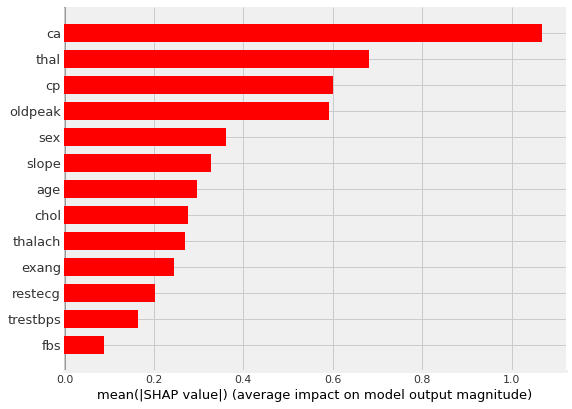

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color='red')


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test.iloc[4,:])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test.iloc[:1000,:])

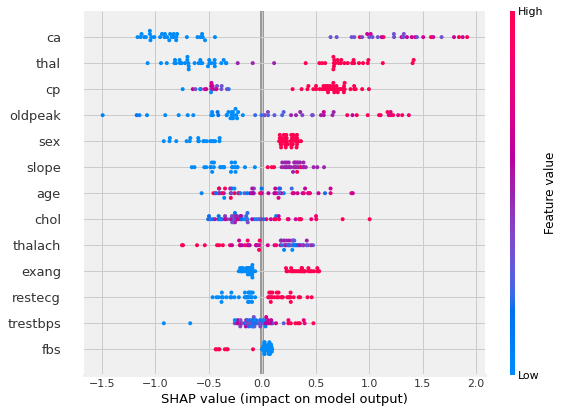

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

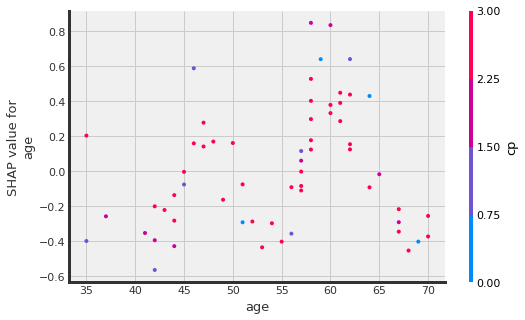

In [ ]:
shap.initjs()
shap.dependence_plot(ind='age', interaction_index='cp',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)